In [27]:
import pygame
import pyglet
import torch
import numpy as np 
import  gym
from PIL import Image
from collections import namedtuple

import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 
import random
from itertools import count
import math 
from IPython.display import clear_output

import matplotlib.pyplot as plt 



# Define our Deep Reinforcement<span style="color:#873260"> Neural Network</span> model : 

In [28]:
# DQN is a child class of nn.Module pre buit class in pytorch for NN 

class DQN (nn.Module):       
    def __init__(self, image_h, image_w):
        super(DQN, self).__init__()
        # Xavier initialization : 
        self.fc1 = nn.Linear(in_features= image_h*image_w*3 , out_features= 24 )
        self.fc2 = nn.Linear(in_features= 24  , out_features= 32)
        self.out = nn.Linear (in_features= 32 , out_features= 2 )
    # specifying how input data is processed through the layers of the model to produce an output
    def forward(self , t ):
        t = torch.flatten(t, start_dim=1)
        t = F.relu (self.fc1(t)) 
        t = F.relu (self.fc2(t))
        t = self.out(t)
        return t 

# define our<span style="color:#873260"> Rplay Memory</span> : 
To enable more stable and efficient learning by breaking temporal correlations, improving data efficiency, and allowing the agent to learn from a diverse set of experiences.

In [31]:
Experiance = namedtuple (
 'Experiance', 
 ('state', 'action' ,'reward' ,'new_state'  )
)


class ReplayMemory ():
    def __init__(self , capacity):
        self.capacity = capacity
        self.memory = []
        self.count = 0 

    def push_experiance (self, experiance):
        if( len(self.memory) < self.capacity):
            self.memory.append(experiance)
            self.count += 1 
        else :
            self.memory[self.count % self.capacity] = experiance
            self.count += 1 

    def sample(self,batch_size):
            return random.sample(self.memory, batch_size)
      
    def can_provide_simple (self,batch_size):
            return (len(self.memory)>= batch_size)


## Define our<span style="color:#873260"> Epsilon Greedy Strategy</span> so we can to either <span style="color:#873260"> Explore/Exploite </span> the envirment : 

In [32]:
class EpsilonGreedyStrategy():
    def __init__(self, epsilon_max , epsilon_min , epsilon_decay):
        self.epsilon_max = epsilon_max # start 
        self.epsilon_min = epsilon_min  # end
        self.decay = epsilon_decay


    def getExplorationRate(self, current_step):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min)*np.exp(-self.decay*current_step)


# Define our<span style="color:#873260"> Agent</span> class:

In [33]:
class Agent():
    def __init__(self,strategy,num_actions, device):
        self.currant_step = 0 
        self.strategy = strategy
        self.num_actions = num_actions
        self.device= device
        
    def selectAction(self, policy_nn , state):
        rate = self.strategy.getExplorationRate(self.currant_step)
        self.currant_step += 1 
        if(rate > random.random()):
             # exploration 
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device)
        else:# exploitation
            with torch.no_grad(): # turn off the gradient since we are using the nn for training
                return policy_nn(state).argmax(dim = 1 ).to(self.device)

# Define a class that handels<span style="color:#873260"> Environment and image preprocessing</span> : 

In [34]:
class CartPoleEnvManager ():
    def __init__(self,device):
        self.device = device 
        self.env = gym.make("CartPole-v1").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done= False 

    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self,mode='human'):
        screen = self.env.render(mode)
        return screen
    
    def numActionsAvailible(self):
        return self.env.action_space.n
    
    def takeAction (self, action):
          new_state, reward, done , info = self.env.step(action.item()) # .item to transfor the tensor to an action
          self.done = done
          return torch.tensor([reward],device=self.device)
    
    def justStarting (self):
        return self.current_screen is None
    
    def getNumState (self):
        return self.env.observation_space.n

    def getState(self):
        if self.justStarting() or self.done:
            self.current_screen = self.get_preprocessed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        

        else: 
            s1 = self.current_screen
            s2 = self.get_preprocessed_screen()
            self.current_screen = s2 
            return s2 - s1 
        
    def getScreenHeight(self):
        return  self.get_preprocessed_screen().shape[2]
    
    def getScreenWidth(self):
        return  self.get_preprocessed_screen().shape[3]
    

    def cropScreen(self, screen ):
        screen_height = screen.shape[1]
        top = int (0.4*screen_height)
        buttom = int (0.8 * screen_height)
        screen = screen[:, top : buttom ,: ]
        return screen
    
    def get_preprocessed_screen(self):
        screen = self.render("rgb_array").transpose((2, 0 , 1))
        screen = self.cropScreen(screen)
        return self.transform_screen_data(screen)
    
    def transform_screen_data(self , screen):
        # convert to float , rescale , convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device)
    
    

In [35]:
def extract_tensors(experiences):
    batch = Experiance(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward )
    t4 = torch.cat(batch.new_state)

    return (t1,t2,t3,t4)

## A function to plot<span style="color:#873260"> Agent Performance Over Time</span>:
plot the duration of the game for each episode


In [36]:
from sysconfig import is_python_build


def plot(values,moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title("Training ...")
    plt.xlabel('Episodes')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period,values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode",len(values),"\n",moving_avg_period,"episode moving avg: ",moving_avg[-1])
    if is_python_build:
        clear_output(wait=True)


def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >=period:
        moving_avg = values.unfold(dimension = 0 , size = period , step = 1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1),moving_avg))
        return moving_avg.numpy()
    
    else :
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()


## QValues Class for<span style="color:#873260">  Calculating Current and Next Q-Values</span> in Deep Q-Learning:
We need current Q-values and next Q-values to use in the Bellman equation and calculate the loss.

In [37]:
class QValues():
    device = "cpu"
    @staticmethod
    def get_current(policy_nn,states,actions):
        return policy_nn(states).gather(dim = 1,index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_nn,nextStates):
        final_state_locations = nextStates.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = nextStates[non_final_state_locations]
        
        
        batch_size = nextStates.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_nn(non_final_states).max(dim=1)[0].detach()
        return values


## Initialization and Choosing the Hyperparameters:

In [38]:
batch_size =256
discount_rate =0.999
epsilon_max = 1.0
epsilon_min = 0.01
epsilon_decay = 0.001
target_update = 10
memory_size = 100000
learning_rate = 0.001
num_episodes = 1000

device= "cpu"
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(epsilon_max, epsilon_min, epsilon_decay)
agent = Agent(strategy, em.numActionsAvailible() , device)
replayMemory = ReplayMemory(memory_size)
policy_nn = DQN(em.getScreenHeight(),em.getScreenWidth()).to(device)
target_nn = DQN(em.getScreenHeight(),em.getScreenWidth()).to(device)
target_nn.load_state_dict(policy_nn.state_dict())
target_nn.eval()   # target_nn is not trainble
optimizer = optim.Adam(params=policy_nn.parameters(), lr= learning_rate)


# Training the agent : 

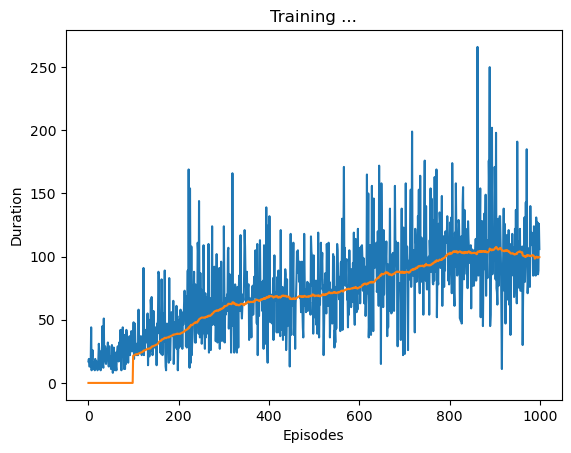

Episode 1000 
 100 episode moving avg:  99.58


In [39]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.getState()

    for timestep in count():
        action = agent.selectAction(policy_nn , state )
        reward = em.takeAction(action)
        nextState = em.getState()

        replayMemory.push_experiance(Experiance(state,action,reward,nextState))
        state = nextState

        if replayMemory.can_provide_simple(batch_size):
            experiances = replayMemory.sample(batch_size)
            states , actions , rewards , nextStates = extract_tensors(experiances)
            current_q_values = QValues.get_current(policy_nn , states , actions)
            next_q_values = QValues.get_next(target_nn , nextStates)
            target_q_values = (next_q_values * discount_rate) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    
    if episode % target_update ==0 :
        target_nn.load_state_dict(policy_nn.state_dict())

em.close()

